# Load data

In [16]:
import xarray as xr

data_dir = 'D:/VScode/Last_deglaciation/data'
ds_sat_EOFs = xr.open_dataset(data_dir + '/ds_sat_EOFs.nc')
ds_sat_EOFs

<xarray.Dataset>
Dimensions:                (age: 65, lat: 96, lon: 144)
Coordinates:
  * lat                    (lat) float32 -90.0 -88.11 -86.21 ... 88.11 90.0
  * lon                    (lon) float32 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
  * age                    (age) float32 1.11e+04 1.13e+04 ... 2.37e+04 2.39e+04
Data variables:
    sat                    (age, lat, lon) float32 ...
    sat_std                (age, lat, lon) float32 ...
    sat_centered           (age, lat, lon) float32 ...
    weight                 (lat) float32 ...
    sat_centered_weighted  (age, lat, lon) float32 ...
    EOF1                   (lat, lon) float32 ...
    EOF2                   (lat, lon) float32 ...

In [3]:
ds_sat_EOFs.info

<bound method Dataset.info of <xarray.Dataset>
Dimensions:                (age: 65, lat: 96, lon: 144)
Coordinates:
  * lat                    (lat) float32 -90.0 -88.11 -86.21 ... 88.11 90.0
  * lon                    (lon) float32 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
  * age                    (age) float32 1.11e+04 1.13e+04 ... 2.37e+04 2.39e+04
Data variables:
    sat                    (age, lat, lon) float32 ...
    sat_std                (age, lat, lon) float32 ...
    sat_centered           (age, lat, lon) float32 ...
    weight                 (lat) float32 ...
    sat_centered_weighted  (age, lat, lon) float32 ...
    EOF1                   (lat, lon) float32 ...
    EOF2                   (lat, lon) float32 ...>

In [17]:
import numpy as np
import xarray as xr
from sklearn.mixture import GaussianMixture

# Assuming ds_sat_EOFs is your xarray Dataset
# 1. Reshape the EOF2 data into a 2D array
eof2_data = ds_sat_EOFs['EOF2'].values
eof2_reshaped = eof2_data.reshape(-1, 1)  # reshaping it to be 2D
# print(eof2_reshaped.shape)

# 2. Fit a GMM
gmm = GaussianMixture(n_components=4)
gmm.fit(eof2_reshaped)

# 3. Predict the labels
labels = gmm.predict(eof2_reshaped)

# If you want to reshape the labels back to the shape of EOF2
labels_reshaped = labels.reshape(eof2_data.shape)

# If you want to add the predicted labels to your xarray dataset
ds_sat_EOFs['class_label'] = (("lat", "lon"), labels_reshaped)


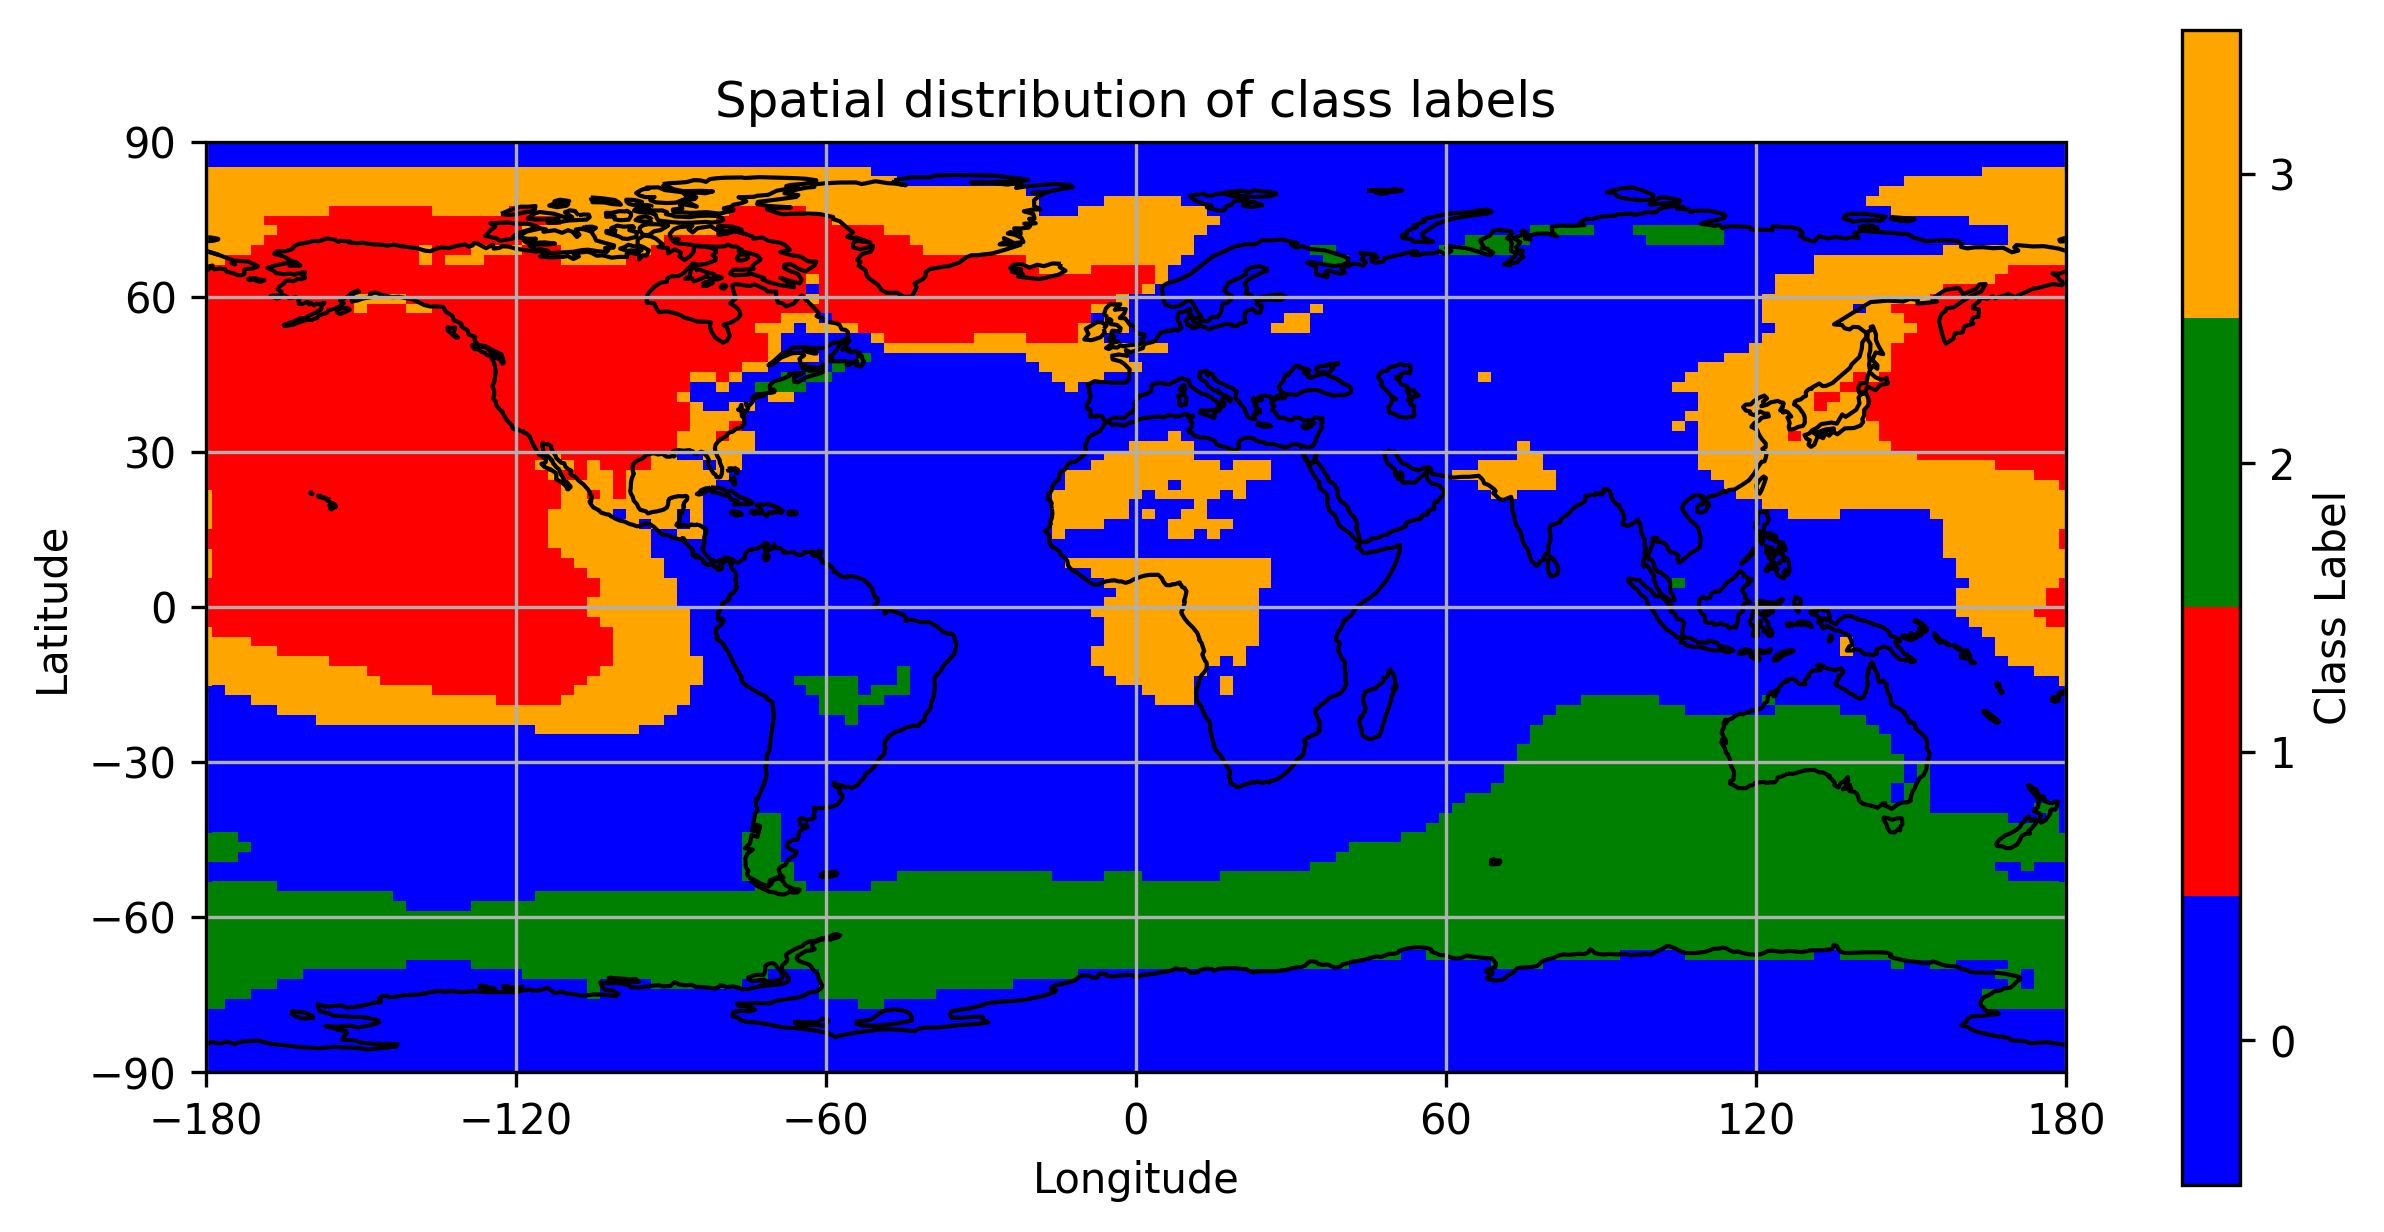

In [18]:
from toolbox import GMM_functions as gf
gf.plot_labels(ds_sat_EOFs)

In [14]:
import numpy as np
import xarray as xr


# label2plot=[]
def find_labels_transition(ds,variable='sat'):

    min_age_list=[]
    labels=[]
    classlabel_age=[]
    sequence_class_age=[]

    ds['transition_age_of_label'] = xr.full_like(ds['sat'].isel(age=0), np.nan)
    for label in np.unique(ds['class_label']):
        # label2plot = label
        label_mask = ds['class_label'] == label
        label_sat = ds[variable].where(label_mask)

        weight=ds['weight'].where(label_mask)
        label_sat=label_sat*weight

        label_sat_average = label_sat.sum(dim=('lat', 'lon'))/weight.sum(dim=('lat', 'lon'))
        
        min_age = ds['age'].isel(age=label_sat_average.argmin(dim='age'))
        # min_sat = label_sat_average.min(dim='age')
        min_age_list.append(min_age.values)
        labels.append(label)
        classlabel_age.append([label,min_age.values])
        
        age_min_sat = xr.where(label_mask, min_age, np.nan)
        ds['transition_age_of_label'] = ds['transition_age_of_label'].where(~label_mask, age_min_sat)

    # compute sequence
    classlabel_age.sort(key=lambda x: x[1], reverse=True)
    ds['sequence'] = xr.full_like(ds['sat'].isel(age=0), np.nan)
    #min_age_list = np.unique(ds['transition_age_of_label'].values[~np.isnan(ds['transition_age_of_label'].values)])
    # min_age_list.sort()
    # print(min_age_list)
    for i in range(len(classlabel_age)):#enumerate(np.unique(ds['class_label'])):
        label_mask = ds['class_label'] == classlabel_age[i][0]
        sequence_class_age.append([i,classlabel_age[i][0],classlabel_age[i][1]])
        ds['sequence'] = xr.where(label_mask, i, ds['sequence'])
    ds['sequence'] = ds['sequence'].fillna(-2147483648).astype(int)

    return ds,sequence_class_age

##############################################################################################
# function to plot the class labels on a map

import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np


def plot_all_label_at_sequence(ds,variable='sat',plot_class=False):
    ds,sequence_class_age=find_labels_transition(ds,variable=variable)
    sequence_label = ds['sequence']
    sat_label = ds['class_label']
    # create a figure and axis
    nrow=len(np.unique(sat_label))
    fig = plt.figure(figsize=(16, 5*nrow),dpi=300)

    colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
    
    for i in np.unique(ds['sequence']):
        label2plot=sequence_class_age[i][1]
        # add coastline and gridlines
        ax = fig.add_subplot(nrow, 2, 2*i+1, projection=ccrs.PlateCarree())
        ax.add_feature(cfeature.COASTLINE)
        ax.gridlines()

        # plot heatmap
        # colors = list(mcolors.TABLEAU_COLORS.values())
        # colors = colors[1:len(np.unique(sat_label))+1]

        cmap = mcolors.ListedColormap(['#ffffff', colors[label2plot]])
        im = ax.pcolormesh(ds.lon, ds.lat, sat_label==label2plot, transform=ccrs.PlateCarree(), cmap=cmap, shading='auto')   
        ax.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
        ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
        # add lon and lat labels
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.set_title(f'Sequence Label: {str(sequence_class_age[i][0])}, Class label: {str(sequence_class_age[i][1])}, Age of transition: {str(int(sequence_class_age[i][2]))}')


    ##########################################
    # calculate average sat data for each label

        # label_mask = ds['class_label'] == label2plot
        # label_sat = ds[variable].where(label_mask)
        # label_sat_average = label_sat.mean(dim=('lat', 'lon'))

        label_mask = ds['class_label'] == label2plot
        label_sat = ds[variable].where(label_mask)

        weight=ds['weight'].where(label_mask)
        label_sat=label_sat*weight

        label_sat_average = label_sat.sum(dim=('lat', 'lon'))/weight.sum(dim=('lat', 'lon'))
        

        min_age = ds['age'].isel(age=label_sat_average.argmin(dim='age'))
        min_sat = label_sat_average.min(dim='age')

        # create axis for the second plot
        ax1 = fig.add_subplot(nrow, 2, 2*i+2)

        # timing for climate transitions, data from Rasmussen et al., 2014, in b2k
        HS1=np.array([17480,14692])-50 # convert to b1950
        BA=np.array([14692,12896])-50
        YD=np.array([12896,11703])-50

        # plot the timing of climate transitions using vertical lines
        ax1.axvline(x=HS1[0],color='black',linestyle='--') # HS1
        ax1.axvline(x=HS1[1],color='black',linestyle='--') # HS1

        ax1.axvline(x=BA[0],color='black',linestyle='--') # BA
        ax1.axvline(x=BA[1],color='black',linestyle='--') # BA

        ax1.axvline(x=YD[0],color='black',linestyle='--') # YD
        ax1.axvline(x=YD[1],color='black',linestyle='--') # YD

        if plot_class:
            # plot all sat data in the same label as light grey lines
            # reshape the label_sat to a 2D array
            label_sat = label_sat.values
            label_sat = label_sat.reshape(label_sat.shape[0], label_sat.shape[1]*label_sat.shape[2])
            print(label_sat.shape)
            for i in range(label_sat.shape[1]):
                ax1.plot(ds['age'],label_sat[:,i], color='lightgray', alpha=0.1)

        ax1.plot(ds.age,label_sat_average,color=colors[label2plot])
        ax1.plot(min_age,min_sat,'ko')
        # print(np.max(ax1.get_ylim()))
        
        # add labels for the vertical lines
        ax1.text(HS1[0]-0.7*(HS1[0]-HS1[1]),np.max(ax1.get_ylim())-0.1*(np.max(ax1.get_ylim())-np.min(ax1.get_ylim())),'HS1',rotation=90)
        ax1.text(BA[0]-0.7*(BA[0]-BA[1]),np.max(ax1.get_ylim())-0.1*(np.max(ax1.get_ylim())-np.min(ax1.get_ylim())),'BA',rotation=90)
        ax1.text(YD[0]-0.7*(YD[0]-YD[1]),np.max(ax1.get_ylim())-0.1*(np.max(ax1.get_ylim())-np.min(ax1.get_ylim())),'YD',rotation=90)

        ax1.set_xlabel('Age')
        ax1.set_ylabel(f'{variable}')
        #ax1.set_title('Class Label: '+str(label2plot))

    plt.show()

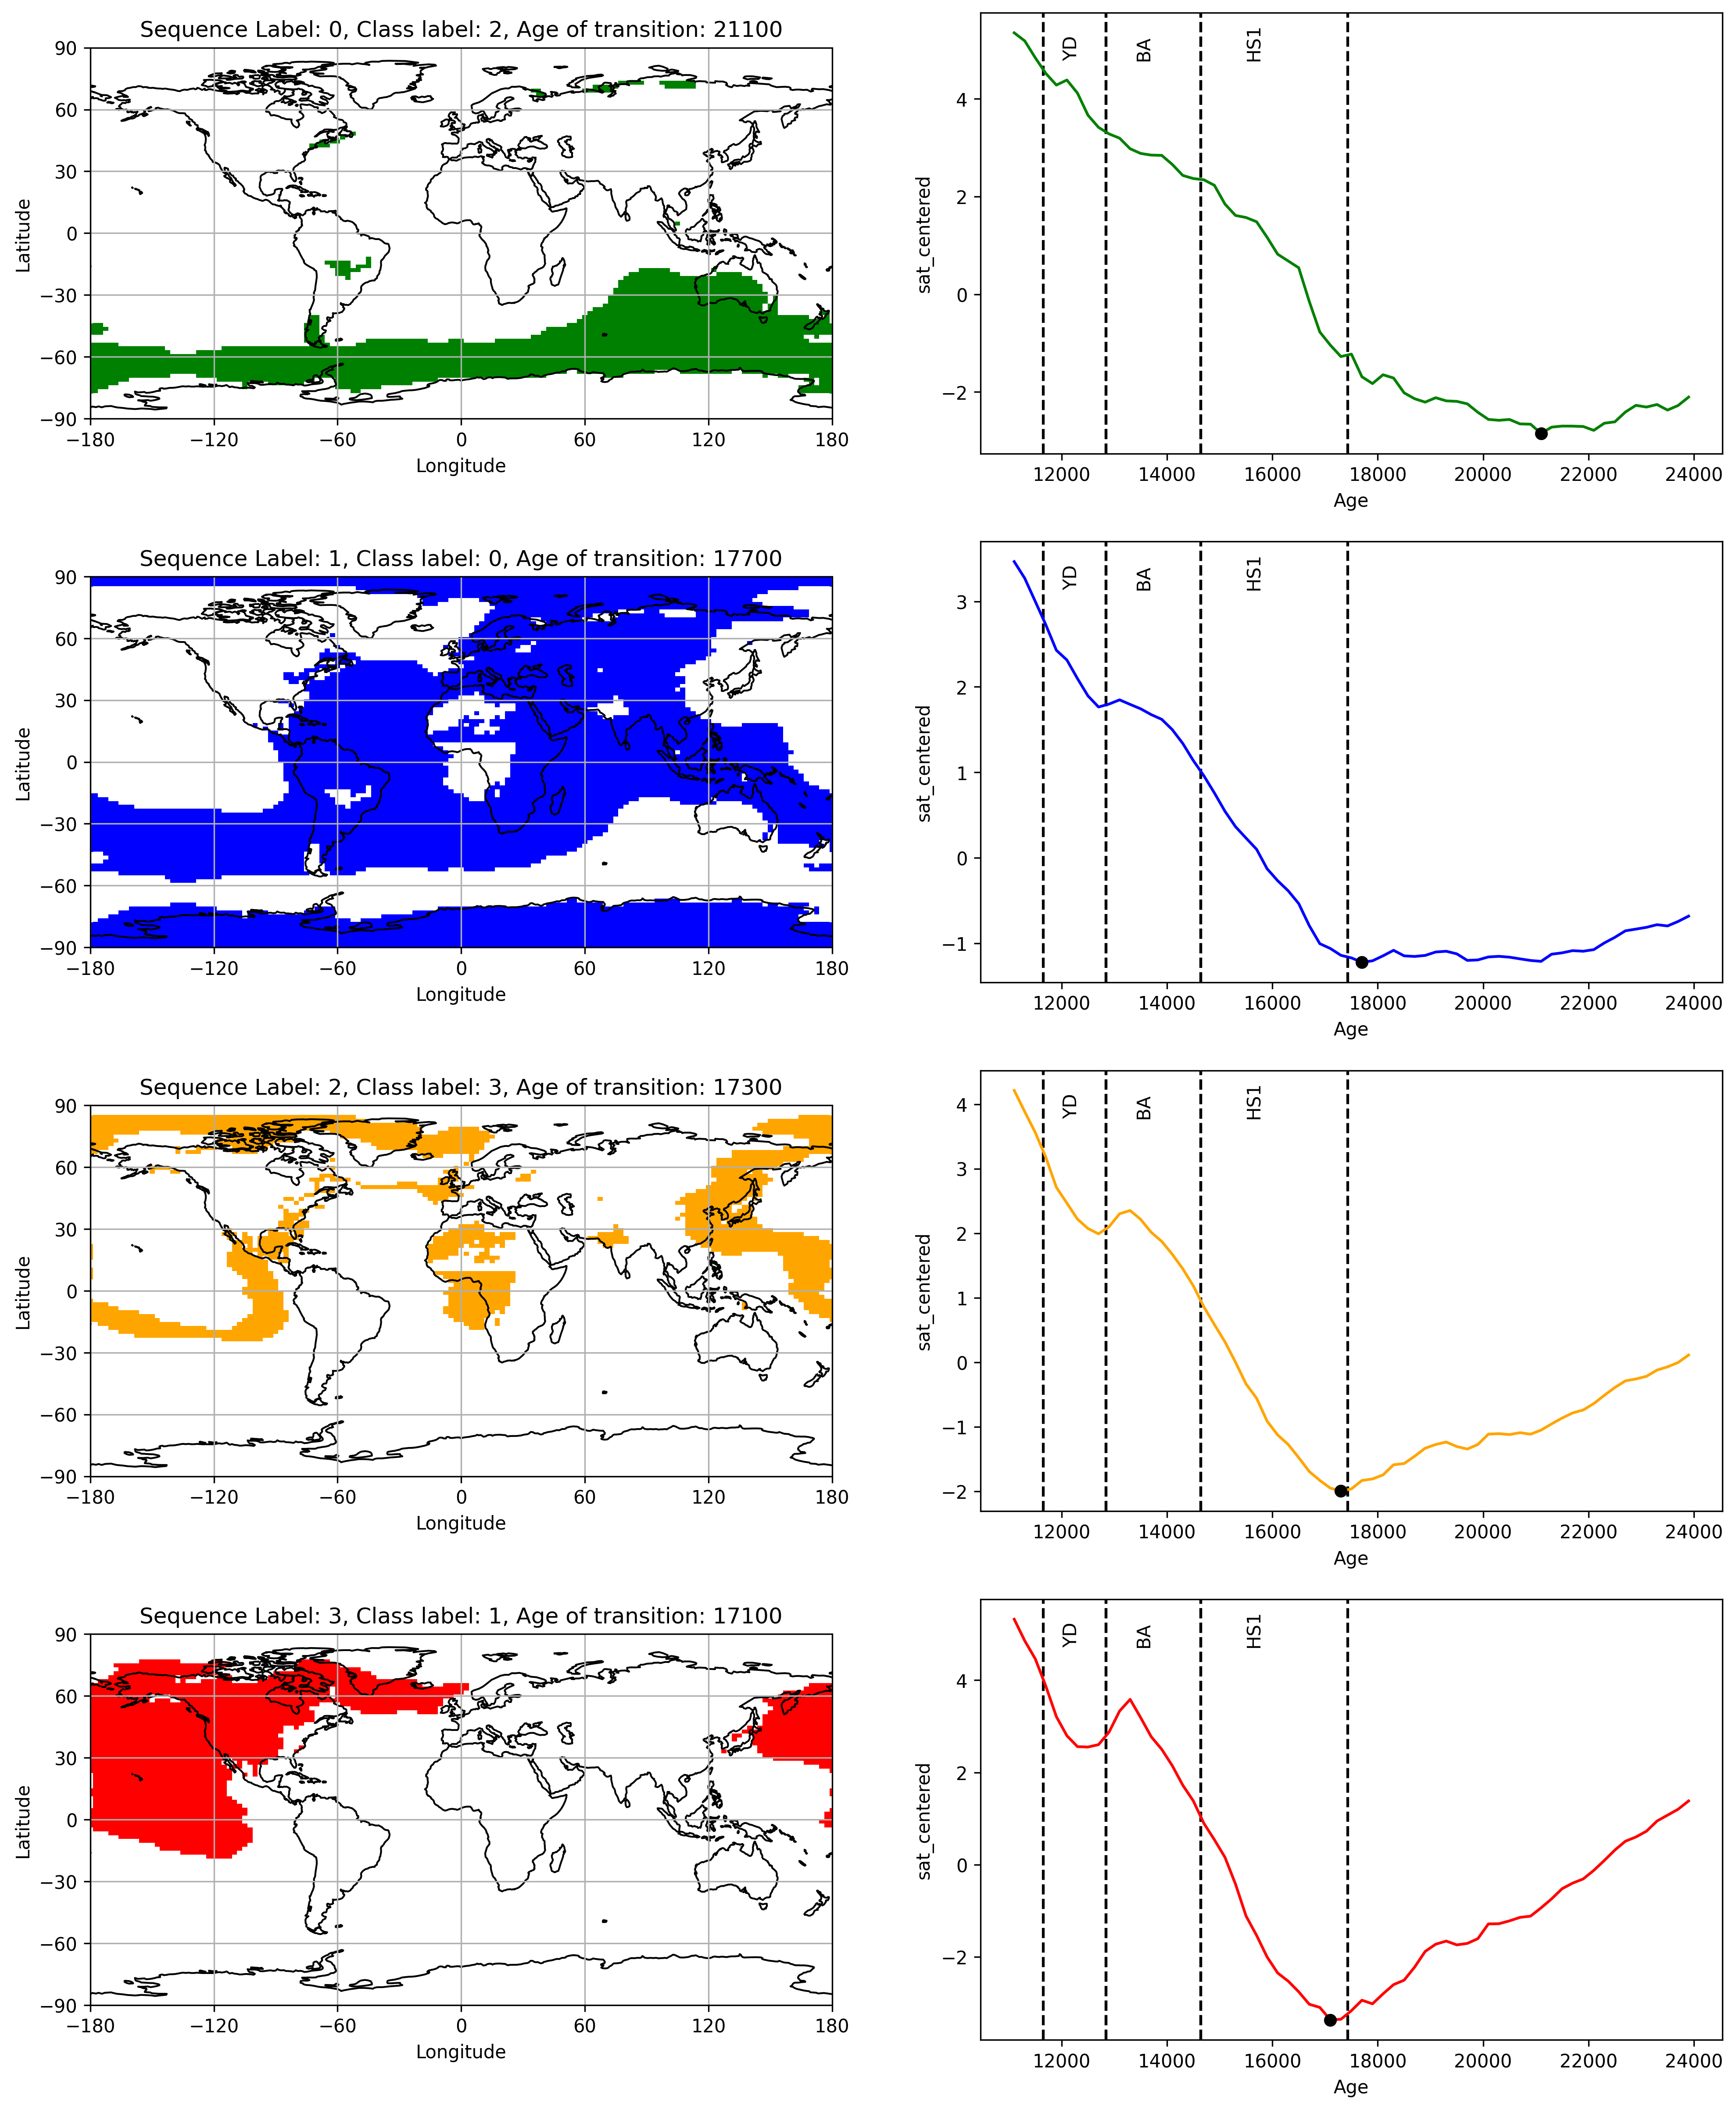

In [19]:
plot_all_label_at_sequence(ds_sat_EOFs,variable='sat_centered')